In [1]:
from functools import partial

import matplotlib.pyplot as plt

from superfv import EulerSolver, plot_2d_slice, turbulent_power_specta, plot_timeseries
from superfv.initial_conditions import decaying_isotropic_turbulence

In [2]:
seed = 1
N = 64
T = [0.01]  # [0.05, 0.1, 0.15]

configs = {
    "p0": dict(riemann_solver="hllc", p=0),
    "MUSCL-Hancock": dict(
        riemann_solver="hllc",
        p=1,
        MUSCL=True,
        MUSCL_limiter="PP2D",
        flux_recipe=2,
    ),
    # "ZS3-T": dict(
    #     riemann_solver="hllc",
    #     p=3,
    #     flux_recipe=2,
    #     lazy_primitives=True,
    #     ZS=True,
    #     include_corners=True,
    #     adaptive_dt=False,
    #     CFL=0.4,
    #     PAD={"rho": (0, None)},
    # ),
    "ZS3": dict(
        riemann_solver="hllc",
        p=3,
        flux_recipe=2,
        lazy_primitives=True,
        ZS=True,
        GL=True,
        include_corners=True,
        PAD={"rho": (0, None)},
    ),
    "MM3": dict(
        riemann_solver="hllc",
        p=3,
        flux_recipe=2,
        lazy_primitives=True,
        MOOD=True,
        limiting_vars=("rho", "vx", "vy"),
        cascade="muscl",
        MUSCL_limiter="PP2D",
        max_MOOD_iters=2,
        NAD=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-8,
        include_corners=True,
        PAD={"rho": (0, None)},
    ),
}

In [3]:
sims = {}
for name, config in configs.items():
    print(f"Running simulation: {name}")
    sim = EulerSolver(
        ic=partial(decaying_isotropic_turbulence, seed=seed, M=10, slope=-5 / 3),
        isothermal=True,
        nx=N,
        ny=N,
        **config,
    )

    try:
        sim.run(
            T,
            q_max=2,
            allow_overshoot=True,
            muscl_hancock=config.get("MUSCL", False),
            log_freq=20,
        )
        sims[name] = sim
    except RuntimeError as e:
        print(f"Simulation '{name}' failed: {e}")

Running simulation: p0
Step #21 @ t=1.00e-02 | dt=5.17e-04 | min(rho)=1.04e-01, min(P)=1.04e-01 | (done)                   
Running simulation: MUSCL-Hancock
Step #23 @ t=1.01e-02 | dt=4.56e-04 | min(rho)=2.25e-02, min(P)=2.25e-02 | (done)                   
Running simulation: ZS3
Step #23 @ t=1.00e-02 | dt=4.49e-04 | min(rho)=2.31e-03, min(P)=2.31e-03 | (done)                   
Running simulation: MM3
Step #23 @ t=1.01e-02 | dt=4.47e-04 | min(rho)=8.03e-03, min(P)=8.03e-03 | (done)                   


/Users/jonathan/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.01 not exactly matched in mesh; using nearest: 0.0100521
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.01 not exactly matched in mesh; using nearest: 0.0100521
  warnings.warn(


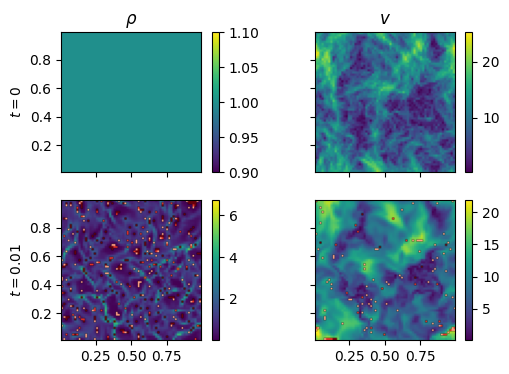

In [4]:
sim = sims["MM3"]

fig, axs = plt.subplots(
    len(T) + 1, 2, sharex=True, sharey=True, figsize=(6, (len(T) + 1) * 2)
)

axs[0, 0].set_title(r"$\rho$")
axs[0, 1].set_title(r"$v$")

for i, t in enumerate([0] + T):
    axs[i, 0].set_ylabel(f"$t={t}$")
    plot_2d_slice(
        sim,
        axs[i, 0],
        "rho",
        cell_averaged=True,
        colorbar=True,
        t=t,
        overlay_troubles=True,
        troubles_alpha=1.0,
    )
    plot_2d_slice(
        sim,
        axs[i, 1],
        "v",
        cell_averaged=True,
        colorbar=True,
        t=t,
        overlay_troubles=True,
        troubles_alpha=1.0,
    )

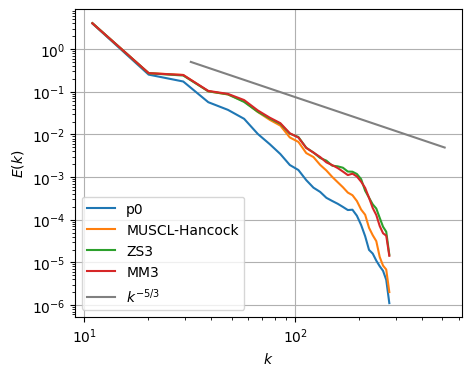

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$E(k)$")
ax.set_xscale("log")
ax.set_yscale("log")

for name, sim in sims.items():
    w = sim.snapshots[-1]["w"]
    k_centers, E_k = turbulent_power_specta(
        sim.xp, sim.variable_index_map, w, sim.mesh, nbins=30, binmode="linear"
    )

    ax.plot(k_centers, E_k, marker="none", mfc="none", linestyle="-", label=name)

ax.plot(
    [32, 512], [5e-1, 5e-1 * (512 / 32) ** (-5 / 3)], label=r"$k^{-5/3}$", color="gray"
)

ax.legend()
ax.grid()

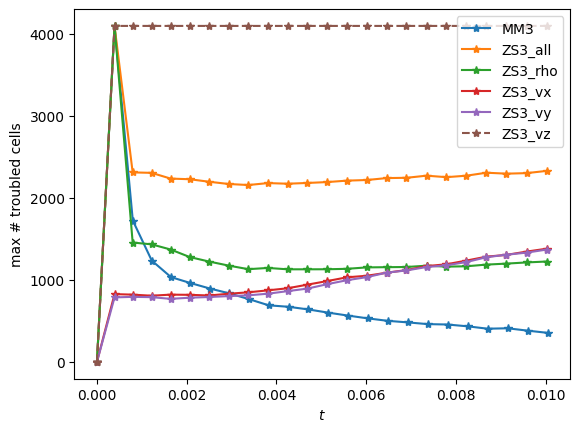

In [6]:
fig, ax = plt.subplots()

ax.set_xlabel(r"$t$")
ax.set_ylabel("max # troubled cells")

plot_timeseries(sims["MM3"], ax, "n_troubled_cells", label="MM3", marker="*")

plot_timeseries(sims["ZS3"], ax, "n(1-theta)", label="ZS3_all", marker="*")
for var in ["rho", "vx", "vy"]:
    plot_timeseries(
        sims["ZS3"], ax, f"n(1-theta)_{var}", label=f"ZS3_{var}", marker="*"
    )
plot_timeseries(
    sims["ZS3"], ax, "n(1-theta)_vz", label="ZS3_vz", marker="*", linestyle="--"
)

ax.legend()